# 🧠 Klasifikasi Gambar Tumor Otak dengan CNN

## Download Dataset

In [69]:
import kagglehub
tumor_otak_path = kagglehub.dataset_download('navoneel/brain-mri-images-for-brain-tumor-detection')

print('Data source import complete.')

100%|██████████| 15.1M/15.1M [00:00<00:00, 93.1MB/s]

Extracting files...


Data source import complete.


## 🔽 1. Mengunduh Dataset dari Kaggle

Pada tahap ini, kita menggunakan library `kagglehub` untuk mengunduh dataset MRI otak yang digunakan dalam deteksi tumor otak. Dataset ini bersumber dari Kaggle, yaitu: [`navoneel/brain-mri-images-for-brain-tumor-detection`](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection).

Dataset ini berisi gambar MRI otak yang sudah diklasifikasikan menjadi dua folder:
- `yes`: Mengandung tumor
- `no`: Tidak mengandung tumor


In [70]:
from google.colab import files
uploaded = files.upload()


Saving brain_tumor_dataset.zip to brain_tumor_dataset (3).zip


In [71]:
import zipfile

with zipfile.ZipFile("brain_tumor_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("brain_tumor_dataset")

print("✅ Sukses diekstrak ke folder 'brain_tumor_dataset'")


✅ Sukses diekstrak ke folder 'brain_tumor_dataset'


In [72]:
import os
print(os.listdir("brain_tumor_dataset"))  # Harusnya berisi: ['yes', 'no']


['yes', 'no', 'brain_tumor_dataset']


In [73]:
tumor_images = load_images("brain_tumor_dataset/yes")
no_tumor_images = load_images("brain_tumor_dataset/no")


## Import Library

## 📦 2. Import Library yang Dibutuhkan

Pada bagian ini, kita mengimpor berbagai library penting yang akan digunakan dalam proyek deteksi tumor otak dari citra MRI.

Berikut penjelasan masing-masing library:

- `PIL.Image` dan `cv2`: Digunakan untuk membaca dan memproses gambar.
- `numpy`: Untuk manipulasi array dan perhitungan numerik.
- `tensorflow` dan `keras`: Untuk membangun dan melatih model deep learning (CNN).
- `matplotlib.pyplot`: Untuk menampilkan grafik dan visualisasi.
- `warnings`: Untuk menyembunyikan pesan peringatan yang tidak terlalu penting.
- `io` dan `google.colab.files`: Untuk keperluan input/output file di Google Colab.


In [74]:
# Import Library
from PIL import Image
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
import cv2
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import matplotlib.pyplot as plt
import io
from google.colab import files

## Import Dataset

## 🖼️ 3. Fungsi untuk Memuat dan Memproses Gambar

Untuk dapat digunakan dalam pelatihan model, gambar MRI otak perlu diproses terlebih dahulu. Oleh karena itu, kita membuat fungsi `load_images()`.

Fungsi ini akan:
1. Membaca semua gambar dari folder yang diberikan (`directory`).
2. Mengubah ukuran gambar menjadi **224x224 piksel**, agar seragam.
3. Mengonversi gambar ke format RGB (3 saluran warna).
4. Mengubah gambar menjadi array NumPy dan menormalisasi nilainya menjadi 0–1.
5. Menyimpan semua gambar dalam sebuah list dan mengembalikannya.





In [75]:
# Fungsi untuk Load Gambar
def load_images(directory):
    images = []
    for filename in os.listdir(directory):
        img = Image.open(os.path.join(directory, filename))
        img = img.resize((224, 224))
        img = img.convert('RGB')
        img = np.array(img) / 255.0
        images.append(img)
    return images

## 📥 Load Gambar dari Dataset

Setelah dataset berhasil diekstrak, langkah berikutnya adalah memuat citra MRI dari dua folder utama, yaitu:

- `yes/` → berisi gambar MRI yang mengandung tumor otak.
- `no/` → berisi gambar MRI tanpa tumor otak.

Kami menggunakan fungsi `load_images()` yang sudah dibuat sebelumnya untuk membaca gambar dari dua folder tersebut. Gambar diubah ke ukuran 224x224 piksel, dikonversi ke format RGB, dan dinormalisasi dengan membagi nilai pikselnya dengan 255.


In [76]:
# Load gambar langsung dari folder hasil ekstrak ZIP
tumor_images = load_images("brain_tumor_dataset/yes")
no_tumor_images = load_images("brain_tumor_dataset/no")


## 🖼️ Visualisasi Gambar Dataset

Untuk memastikan dataset telah berhasil dimuat dengan benar, kami menampilkan beberapa contoh gambar dari dua kelas berikut:

- Baris pertama: Gambar MRI dengan **tumor otak**
- Baris kedua: Gambar MRI tanpa **tumor**

Visualisasi ini juga membantu kita memahami perbedaan visual antara gambar-gambar dari kedua kelas tersebut, sebelum melatih model.



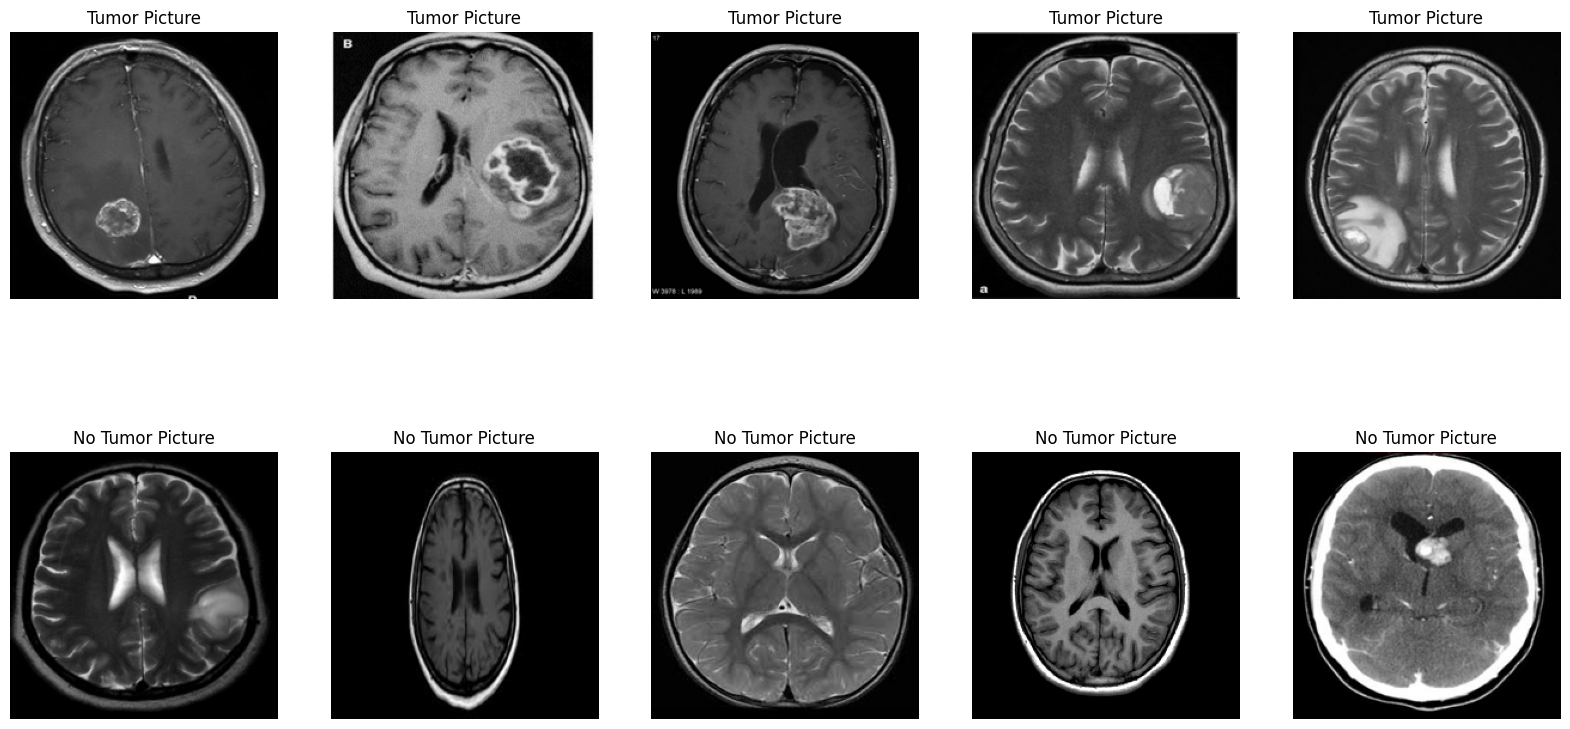

In [77]:
# Visualisasi gambar
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for i in range(5):
    axes[0, i].imshow(tumor_images[i])
    axes[0, i].set_title('Tumor Picture')
    axes[0, i].axis('off')

for i in range(5):
    axes[1, i].imshow(no_tumor_images[i])
    axes[1, i].set_title('No Tumor Picture')
    axes[1, i].axis('off')

plt.show()

## 📊 Jumlah Gambar Tumor Otak

Untuk mengetahui jumlah gambar MRI yang termasuk dalam kategori **tumor otak**, kami menggunakan fungsi `len()` pada list `tumor_images`. List ini sebelumnya telah diisi oleh fungsi `load_images()` yang memuat semua gambar dari folder `brain_tumor_dataset/yes`.


In [78]:
len(tumor_images)

155

## 📊 Jumlah Gambar Tanpa Tumor Otak

Selain gambar MRI yang mengandung tumor, dataset juga menyediakan gambar MRI **tanpa tumor**, yang dimuat ke dalam list `no_tumor_images`. Untuk mengetahui jumlahnya, digunakan fungsi `len()`:


In [79]:
len(no_tumor_images)

98

## 🧠 Variabel `tumor_images`

Variabel `tumor_images` merupakan list (daftar) yang berisi kumpulan gambar MRI dari pasien yang terdeteksi **mengalami tumor otak**. Gambar-gambar ini diambil dari folder `brain_tumor_dataset/yes` dan dimuat menggunakan fungsi `load_images()`.

Setiap gambar dalam `tumor_images` telah melalui proses:
- **Resize** menjadi ukuran 224x224 piksel
- **Konversi ke RGB** (3 channel warna)
- **Normalisasi nilai piksel** dengan membaginya dengan 255 agar berada dalam rentang [0, 1]


In [80]:
tumor_images

[array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]),
 array([[[1.        , 1.        , 1.        ],
        

## Labeling

## 🏷️ Pemberian Label pada Data Gambar

Setelah gambar MRI dimuat, langkah selanjutnya adalah **memberikan label** untuk setiap gambar, agar model dapat belajar membedakan antara gambar yang mengandung tumor dan yang tidak.

Fungsi `assign_labels()` digunakan untuk membuat label dalam bentuk array NumPy:

- Gambar dengan **tumor otak** diberi label `1`
- Gambar tanpa tumor diberi label `0`



In [81]:
def assign_labels(tumor_images, no_tumor_images):
    tumor_labels = np.ones(len(tumor_images))
    no_tumor_labels = np.zeros(len(no_tumor_images))
    return tumor_labels, no_tumor_labels
tumor_labels, no_tumor_labels = assign_labels(tumor_images, no_tumor_images)

## 🧾 Variabel `tumor_labels`

Variabel `tumor_labels` merupakan array NumPy yang berisi **label untuk gambar MRI yang mengandung tumor otak**.

Label yang digunakan adalah:
- `1` → untuk gambar MRI dengan **tumor**

Label ini dibuat menggunakan fungsi `assign_labels()` yang menghasilkan array dengan panjang sebanyak jumlah gambar tumor. Setiap elemen dari array ini bernilai 1, karena seluruh gambar dalam `tumor_images` berasal dari kategori tumor.


In [82]:
tumor_labels

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

## 🧾 Variabel `no_tumor_labels`

Variabel `no_tumor_labels` adalah array NumPy yang berisi **label untuk gambar MRI tanpa tumor otak**.

Label yang digunakan adalah:
- `0` → untuk gambar MRI **tanpa tumor**

Label ini dibuat menggunakan fungsi `assign_labels()`, yang akan menghasilkan array dengan panjang sesuai jumlah gambar pada `no_tumor_images`. Seluruh elemen array ini bernilai `0`, karena seluruh gambar dalam kategori ini adalah gambar **non-tumor**.


In [83]:
no_tumor_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## 🧩 Penggabungan Data dan Label

Setelah gambar dan label dari masing-masing kelas (tumor dan non-tumor) berhasil dimuat dan diberi label, langkah selanjutnya adalah **menggabungkan seluruh data** menjadi satu dataset utuh yang siap untuk pelatihan.


In [84]:
data = tumor_images + no_tumor_images
labels = np.concatenate((tumor_labels, no_tumor_labels), axis=0)

## 🖼️ Variabel `data`

Variabel `data` adalah sebuah list Python yang berisi **gabungan dari seluruh gambar MRI**, baik yang mengandung tumor maupun yang tidak.

Data ini dihasilkan dengan cara menggabungkan dua list:
- `tumor_images` → gambar dengan tumor otak
- `no_tumor_images` → gambar tanpa tumor otak


In [85]:
data

[array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]),
 array([[[1.        , 1.        , 1.        ],
        

## 🏷️ Variabel `labels`

Variabel `labels` adalah sebuah array NumPy yang berisi **label untuk seluruh gambar MRI** di dalam variabel `data`.

Label ini diperoleh dengan cara menggabungkan dua array:
- `tumor_labels` → berisi label `1` untuk gambar yang mengandung tumor
- `no_tumor_labels` → berisi label `0` untuk gambar tanpa tumor


In [86]:
labels

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## 🔍 Pemeriksaan Bentuk Gambar: `data[0].shape`

Untuk memastikan bahwa setiap gambar dalam dataset memiliki bentuk (dimensi) yang sesuai dengan input model, kita dapat memeriksa bentuk salah satu gambar, misalnya gambar pertama:



In [87]:
data[0].shape

(224, 224, 3)

## Split Data

## 🧪 Konversi Data dan Label ke NumPy Array

Setelah seluruh gambar (`data`) dan label (`labels`) digabungkan, langkah berikutnya adalah mengonversi keduanya ke dalam format **NumPy array** agar lebih efisien untuk proses pelatihan model.


In [88]:
X = np.array(data)
y = np.array(labels)

## ✂️ Membagi Data: `train_test_split`

Sebelum melatih model, dataset perlu dibagi menjadi dua bagian: **data pelatihan (training)** dan **data pengujian (testing)**. Ini dilakukan agar model dapat belajar dari sebagian data, dan diuji kemampuannya pada data yang belum pernah dilihat.



In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 🔁 Membuat Dataset TensorFlow dan Visualisasi

Setelah data dibagi menjadi data pelatihan dan pengujian, kita dapat mengonversinya ke dalam format `tf.data.Dataset`. Format ini memungkinkan pemrosesan data yang lebih efisien dan terstruktur saat digunakan dalam pelatihan model.


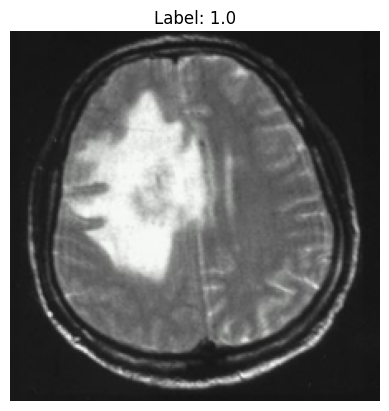

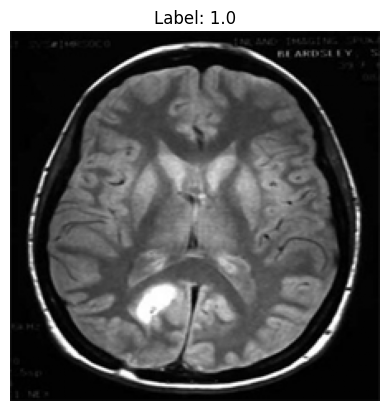

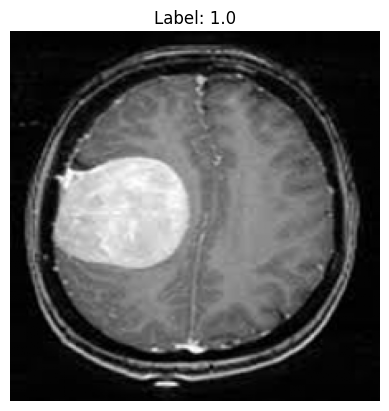

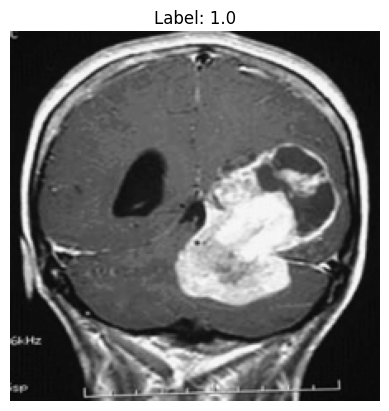

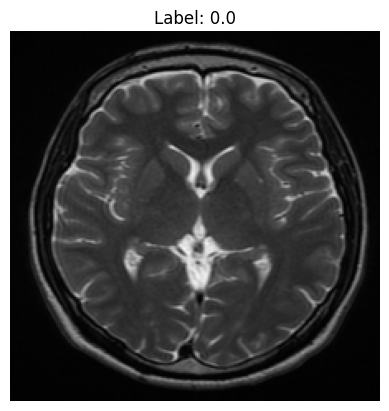

In [90]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

for image, label in train.take(5):
    plt.figure()
    plt.imshow(image.numpy())
    plt.title('Label: {}'.format(label.numpy()))
    plt.axis('off')
    plt.show()

## Training Model

## 🧪 Membuat Dataset Validasi dari Dataset Pelatihan

Setelah membuat `train` dataset dari data pelatihan (`X_train`, `y_train`), kita juga perlu menyisihkan sebagian kecil data sebagai **data validasi**.

Data validasi digunakan untuk:
- Memantau performa model saat pelatihan (tanpa menyentuh data pengujian)
- Mencegah overfitting terhadap data pelatihan


In [91]:
validation_size = int(0.1 * 202)
train = train.skip(validation_size)
val = train.take(validation_size)

## 📦 Membuat Batch Data

Agar pelatihan model berjalan lebih efisien, dataset dibagi ke dalam **batch**—yakni kelompok kecil data yang diproses sekaligus dalam satu iterasi pelatihan.


In [92]:
BATCH_SIZE = 32
train = train.batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)
val = val.batch(BATCH_SIZE)

## 🧠 Arsitektur Model CNN (Convolutional Neural Network)

Model yang digunakan adalah model **Sequential** dari TensorFlow Keras, yang dibangun secara bertahap lapis demi lapis. Model ini dirancang untuk mendeteksi tumor otak dari gambar MRI.

In [93]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (224,224,3), padding='valid'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │   100,933,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,935,041 (385.04 MB)

 Trainable params: 100,935,041 (385.04 MB)

 Non-trainable params: 0 (0.00 B)

## ⚙️ Kompilasi dan Pelatihan Model CNN

Setelah arsitektur model selesai dibuat, langkah selanjutnya adalah **kompilasi** dan **pelatihan** model menggunakan data yang telah dibagi sebelumnya.



In [94]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train, validation_data = val, epochs = 10, verbose = 1)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.5370 - loss: 16.6910 - val_accuracy: 0.4000 - val_loss: 6.4726
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.6102 - loss: 4.7811 - val_accuracy: 0.8500 - val_loss: 3.6916
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7483 - loss: 2.8642 - val_accuracy: 0.6500 - val_loss: 1.5815
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7384 - loss: 1.6806 - val_accuracy: 0.8500 - val_loss: 1.0618
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8352 - loss: 0.7376 - val_accuracy: 0.8500 - val_loss: 0.8446
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8678 - loss: 0.5456 - val_accuracy: 0.9000 - val_loss: 0.2946
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8977 - loss: 0.2851 - val_accuracy: 0.9000 - val_loss: 0.1786
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.9248 - loss: 0.2063 - val_accuracy: 0.9500 - val_loss: 0.1134
Epoch 9

## 📊 Evaluasi Model pada Data Pengujian

Setelah model selesai dilatih menggunakan data pelatihan dan divalidasi pada data validasi, langkah berikutnya adalah **mengukur performa model pada data pengujian (testing set)**.

In [95]:
evaluation = model.evaluate(test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - accuracy: 0.7729 - loss: 0.4403


## 📈 Visualisasi Akurasi Model Selama Pelatihan

Untuk mengetahui perkembangan performa model dari waktu ke waktu (per epoch), kita bisa memvisualisasikan **akurasi pada data pelatihan** dan **akurasi pada data validasi**.


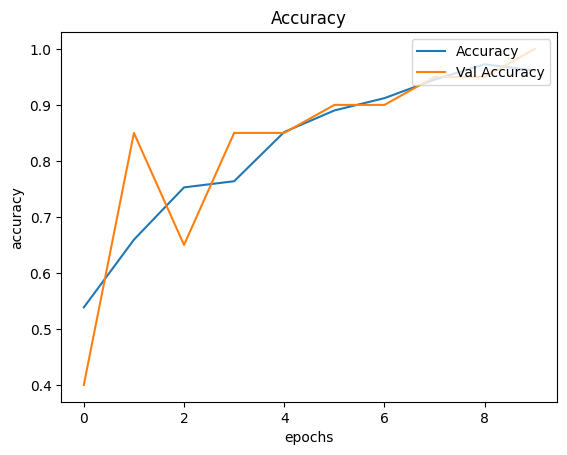

In [96]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy' , 'Val Accuracy'], loc = 'upper right')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## 📉 Visualisasi Nilai Loss Selama Pelatihan

Selain akurasi, kita juga perlu memantau **nilai loss** (kerugian) untuk memahami seberapa baik model belajar. Nilai loss menunjukkan seberapa jauh prediksi model dari nilai sebenarnya — semakin kecil, semakin baik.



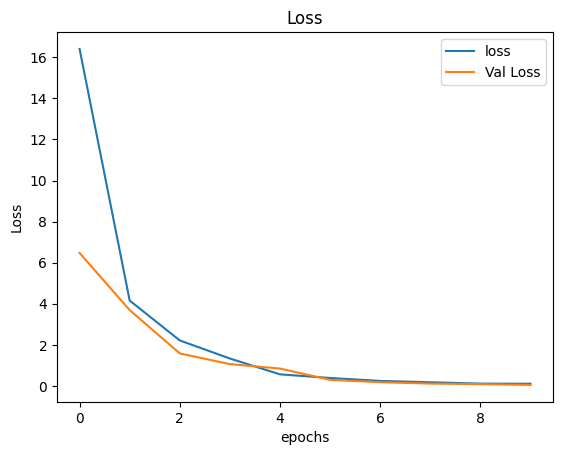

In [97]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'Val Loss'], loc = 'upper right')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()

## 💾 Menyimpan Model Hasil Pelatihan

Setelah model CNN selesai dilatih dan dievaluasi, penting untuk **menyimpan model** agar bisa digunakan kembali di lain waktu tanpa perlu melatih ulang dari awal.
]

In [98]:
model.save("/tumor_otak.h5")

## Test Model

## 🔍 Prediksi Tumor dari Gambar MRI

Setelah model disimpan dan dimuat kembali, kita dapat menggunakannya untuk **memprediksi gambar baru** yang diunggah oleh pengguna.

In [99]:
def load_uploaded_image(image_bytes):
    img = Image.open(io.BytesIO(image_bytes))
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = img_array / 255.0
    return img_array

def predict_image(image_bytes):
    img_array = load_uploaded_image(image_bytes)
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        return "Tumor detected"
    else:
        return "No tumor detected"

## 📤 Upload dan Prediksi Gambar MRI Otak

Pada bagian ini, pengguna dapat **mengunggah gambar MRI** otak secara manual, kemudian model akan melakukan **prediksi otomatis** apakah gambar tersebut mengandung tumor atau tidak.



Saving 12 no.jpg to 12 no (1).jpg


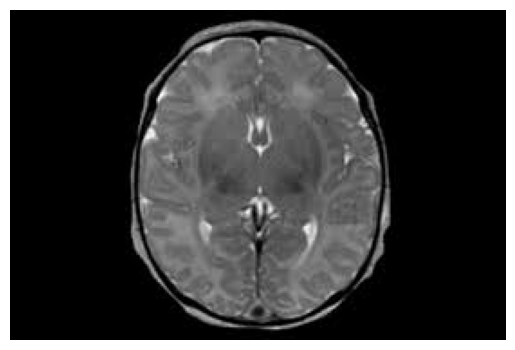

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
No tumor detected


In [102]:
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
image_bytes = uploaded[file_name]
img = Image.open(io.BytesIO(image_bytes))

plt.imshow(img)
plt.axis('off')
plt.show()

result = predict_image(image_bytes)
print(result)